Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---


Let's use assignment2 model, and add a new parameter **beta**, actually we don't what values **beta** should be, we could set it as 0.001 firstly, and then tune it!


In [5]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta = tf.placeholder(tf.float32)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  # we use L2 regularization
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels = tf_train_labels, logits = logits)) + beta * tf.nn.l2_loss(weights)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [6]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : 0.001}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 22.673918
Minibatch accuracy: 4.7%
Validation accuracy: 12.5%
Minibatch loss at step 500: 2.255545
Minibatch accuracy: 85.2%
Validation accuracy: 75.7%
Minibatch loss at step 1000: 1.590626
Minibatch accuracy: 82.0%
Validation accuracy: 78.0%
Minibatch loss at step 1500: 0.950144
Minibatch accuracy: 85.2%
Validation accuracy: 79.8%
Minibatch loss at step 2000: 0.889764
Minibatch accuracy: 85.9%
Validation accuracy: 80.3%
Minibatch loss at step 2500: 0.729431
Minibatch accuracy: 81.2%
Validation accuracy: 81.4%
Minibatch loss at step 3000: 0.794831
Minibatch accuracy: 81.2%
Validation accuracy: 81.7%
Test accuracy: 88.7%


Now, the test accuracy is around 88-89%, but former model without L2 regularization is around 82%. It's improved!  
But whether or not 0.001 is the best for beta paramenter, We can look into it!

In [9]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.2)]
accuracy_val = []

for regul in regul_val:
  with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : regul}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
    accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


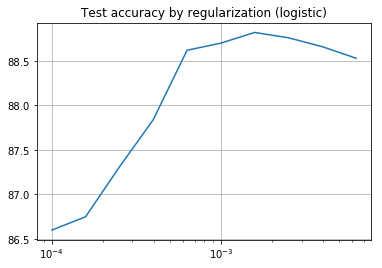

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization')
plt.show()

We can see 0.001 is not the best from the figure, but is still good enough.  
Then we use 1-hidden layer.

In [13]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta = tf.placeholder(tf.float32)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  logits = tf.matmul(lay1_train, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) + \
      beta * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [14]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : 0.001}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 639.475525
Minibatch accuracy: 11.7%
Validation accuracy: 28.2%
Minibatch loss at step 500: 199.801575
Minibatch accuracy: 75.8%
Validation accuracy: 80.3%
Minibatch loss at step 1000: 113.933022
Minibatch accuracy: 82.0%
Validation accuracy: 81.7%
Minibatch loss at step 1500: 68.195717
Minibatch accuracy: 90.6%
Validation accuracy: 83.8%
Minibatch loss at step 2000: 41.186638
Minibatch accuracy: 92.2%
Validation accuracy: 85.2%
Minibatch loss at step 2500: 25.142754
Minibatch accuracy: 89.8%
Validation accuracy: 86.0%
Minibatch loss at step 3000: 15.482091
Minibatch accuracy: 85.9%
Validation accuracy: 86.8%
Test accuracy: 93.0%


---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

Now, we change the batch_size from 128 to lower values, like 10, 20...

In [16]:
batch_size = 10
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta = tf.placeholder(tf.float32)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  logits = tf.matmul(lay1_train, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) + \
      beta * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [17]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    #offset = step % num_bacthes
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : 0.001}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 818.895813
Minibatch accuracy: 10.0%
Validation accuracy: 19.8%
Minibatch loss at step 500: 6295.328125
Minibatch accuracy: 70.0%
Validation accuracy: 57.0%
Minibatch loss at step 1000: 63016.699219
Minibatch accuracy: 60.0%
Validation accuracy: 55.4%
Minibatch loss at step 1500: 26256.664062
Minibatch accuracy: 60.0%
Validation accuracy: 47.1%
Minibatch loss at step 2000: 367629.906250
Minibatch accuracy: 30.0%
Validation accuracy: 46.6%
Minibatch loss at step 2500: 16305.705078
Minibatch accuracy: 50.0%
Validation accuracy: 40.2%
Minibatch loss at step 3000: 9136.805664
Minibatch accuracy: 30.0%
Validation accuracy: 45.9%
Test accuracy: 50.4%


Apperantly, lower **batch_size** causes large loss and lower Test accuracy, if batch_size is less 5, the loss even cannot converge

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [18]:
batch_size = 10
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta = tf.placeholder(tf.float32)
  dropout_prob = tf.placeholder(tf.float32) # add dropout probility
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    
  drop = tf.nn.dropout(lay1_train, dropout_prob) 

  logits = tf.matmul(lay1_train, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) + \
      beta * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [20]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : 0.001, dropout_prob : 0.5}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 663.864380
Minibatch accuracy: 10.0%
Validation accuracy: 18.6%
Minibatch loss at step 500: 64716.601562
Minibatch accuracy: 50.0%
Validation accuracy: 53.9%
Minibatch loss at step 1000: 526681.875000
Minibatch accuracy: 70.0%
Validation accuracy: 54.3%
Minibatch loss at step 1500: 871666.375000
Minibatch accuracy: 70.0%
Validation accuracy: 41.2%
Minibatch loss at step 2000: 18626412.000000
Minibatch accuracy: 40.0%
Validation accuracy: 34.3%
Minibatch loss at step 2500: 1292116.125000
Minibatch accuracy: 60.0%
Validation accuracy: 43.6%
Minibatch loss at step 3000: 424907.968750
Minibatch accuracy: 30.0%
Validation accuracy: 52.0%
Test accuracy: 56.8%


When we set **batch_size = 10** which is small enough to converge hardly, we could use dropout with 0.5 probility to improve about 5% accuracy!

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [7]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 512

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta = tf.placeholder(tf.float32)
  dropout_prob = tf.placeholder(tf.float32)
  global_step = tf.Variable(0)
 
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal(
        [image_size * image_size, num_hidden_nodes1],
        stddev=np.sqrt(2.0 / (image_size * image_size)))
    )
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], stddev=np.sqrt(2.0 / num_hidden_nodes1)))
  biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
  weights3 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes2, num_labels], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
  biases3 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  drop1 = tf.nn.dropout(lay1_train, dropout_prob)
  lay2_train = tf.nn.relu(tf.matmul(drop1, weights2) + biases2)
  drop2 = tf.nn.dropout(lay1_train, dropout_prob)
  logits = tf.matmul(lay2_train, weights3) + biases3
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) + \
      beta * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3))
  
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 500, 0.9, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
  valid_prediction = tf.nn.softmax(tf.matmul(lay2_valid, weights3) + biases3)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
  test_prediction = tf.nn.softmax(tf.matmul(lay2_test, weights3) + biases3)

In [8]:
num_steps = 10001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : 0.0013, dropout_prob : 0.6}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 4.022943
Minibatch accuracy: 10.2%
Validation accuracy: 28.3%
Minibatch loss at step 1000: 0.918353
Minibatch accuracy: 86.7%
Validation accuracy: 86.2%
Minibatch loss at step 2000: 0.574508
Minibatch accuracy: 92.2%
Validation accuracy: 87.4%
Minibatch loss at step 3000: 0.585209
Minibatch accuracy: 87.5%
Validation accuracy: 87.6%
Minibatch loss at step 4000: 0.665304
Minibatch accuracy: 85.2%
Validation accuracy: 87.8%
Minibatch loss at step 5000: 0.494454
Minibatch accuracy: 89.8%
Validation accuracy: 88.8%
Minibatch loss at step 6000: 0.598259
Minibatch accuracy: 83.6%
Validation accuracy: 88.5%
Minibatch loss at step 7000: 0.542471
Minibatch accuracy: 85.2%
Validation accuracy: 89.0%
Minibatch loss at step 8000: 0.547562
Minibatch accuracy: 86.7%
Validation accuracy: 89.2%
Minibatch loss at step 9000: 0.551219
Minibatch accuracy: 86.7%
Validation accuracy: 89.3%
Minibat